In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
)

plt.rcParams["figure.figsize"] = (7, 5)

DATA_PATH = "creditcard.csv"  # change if your file has a different name

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"{DATA_PATH} not found – upload it or adjust DATA_PATH.")

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()

Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Shape BEFORE dedup: (284807, 31)
Class counts BEFORE:
Class
0    284315
1       492
Name: count, dtype: int64

Shape AFTER dedup: (283726, 31)
Class counts AFTER:
Class
0    283253
1       473
Name: count, dtype: int64


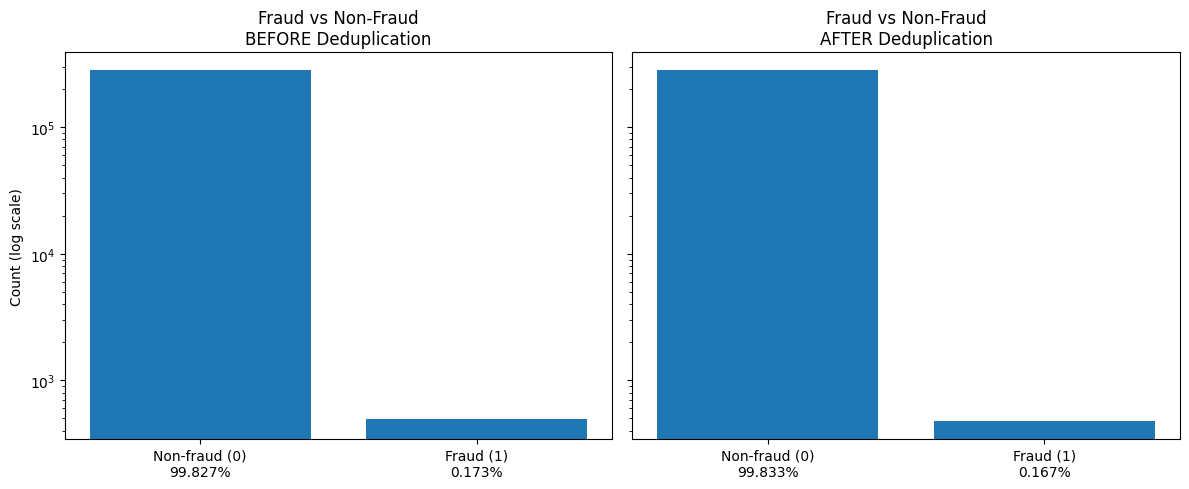

In [ ]:
# ============================
# BEFORE Deduplication
# ============================
class_counts_before = df["Class"].value_counts().sort_index()
total_before = class_counts_before.sum()
pct_before = (class_counts_before / total_before * 100).round(3)

# ============================
# AFTER Deduplication
# ============================
df_nodup = df.drop_duplicates().reset_index(drop=True)
class_counts_after = df_nodup["Class"].value_counts().sort_index()
total_after = class_counts_after.sum()
pct_after = (class_counts_after / total_after * 100).round(3)

print("Shape BEFORE dedup:", df.shape)
print("Class counts BEFORE:")
print(class_counts_before)

print("\nShape AFTER dedup:", df_nodup.shape)
print("Class counts AFTER:")
print(class_counts_after)

labels_before = [
    f"Non-fraud (0)\n{pct_before[0]}%",
    f"Fraud (1)\n{pct_before[1]}%",
]

labels_after = [
    f"Non-fraud (0)\n{pct_after[0]}%",
    f"Fraud (1)\n{pct_after[1]}%",
]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# BEFORE
axes[0].bar(labels_before, class_counts_before.values)
axes[0].set_yscale("log")
axes[0].set_title("Fraud vs Non-Fraud\nBEFORE Deduplication")
axes[0].set_ylabel("Count (log scale)")

# AFTER
axes[1].bar(labels_after, class_counts_after.values)
axes[1].set_yscale("log")
axes[1].set_title("Fraud vs Non-Fraud\nAFTER Deduplication")

plt.tight_layout()
plt.show()

In [ ]:
df_eng = df_nodup.copy()

df_eng["LogAmount"] = np.log1p(df_eng["Amount"])
df_eng["Hour"] = (df_eng["Time"] / 3600.0) % 24.0

df_eng[["Time", "Amount", "LogAmount", "Hour", "Class"]].head()

,Time,Amount,LogAmount,Hour,Class
0,0.0,149.62,5.014760,0.000000,0
1,0.0,2.69,1.305626,0.000000,0
2,1.0,378.66,5.939276,0.000278,0
3,1.0,123.50,4.824306,0.000278,0
4,2.0,69.99,4.262539,0.000556,0


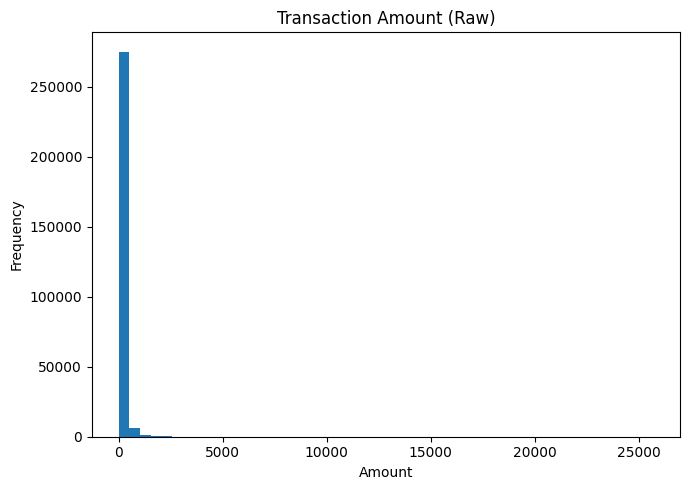

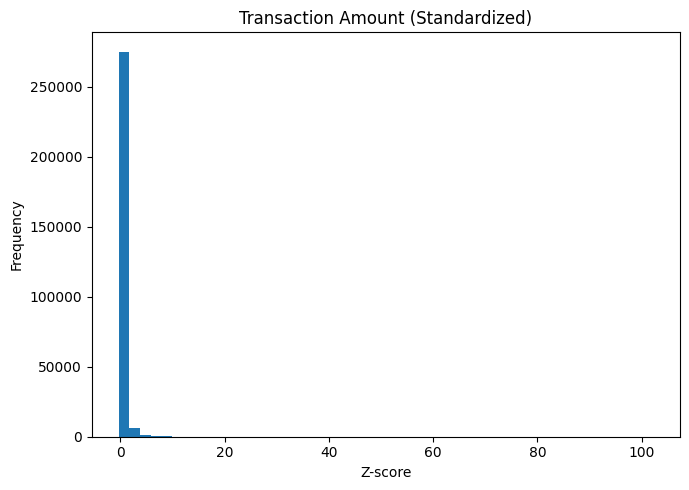

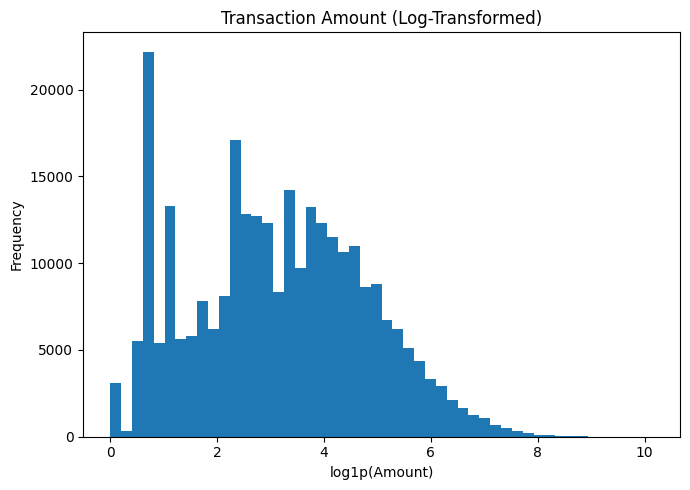

In [ ]:
amount_series = df_eng["Amount"].dropna()
amount = amount_series.values

# Calculate standardized amount using only valid (non-NaN) amounts
# Check if valid_amounts has sufficient data to avoid issues with mean/std
if len(amount_series) > 1 and amount_series.std() != 0:
    amount_z = (amount_series - amount_series.mean()) / amount_series.std()
else:
    # If not enough data or std is zero, create an empty array to avoid plotting errors
    amount_z = np.array([])
    print("Warning: Not enough valid amounts to standardize or standard deviation is zero.")

log_amount = df_eng["LogAmount"].dropna().values

# Raw
plt.figure()
plt.hist(amount, bins=50)
plt.title("Transaction Amount (Raw)")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Standardized
plt.figure()
# Only plot if amount_z is not empty
if amount_z.size > 0:
    plt.hist(amount_z, bins=50)
    plt.title("Transaction Amount (Standardized)")
    plt.xlabel("Z-score")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
else:
    print("Skipping standardized amount plot due to insufficient valid data.")

# Log-transformed
plt.figure()
plt.hist(log_amount, bins=50)
plt.title("Transaction Amount (Log-Transformed)")
plt.xlabel("log1p(Amount)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

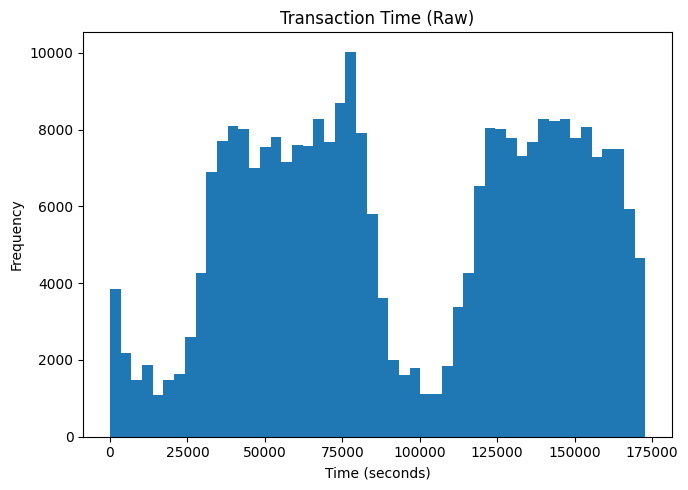

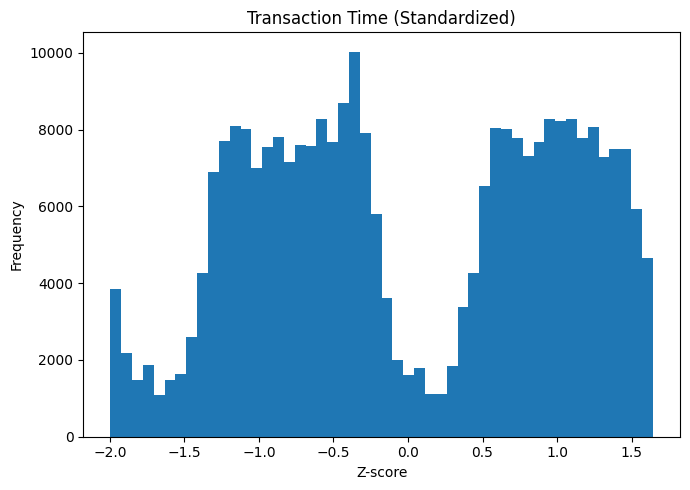

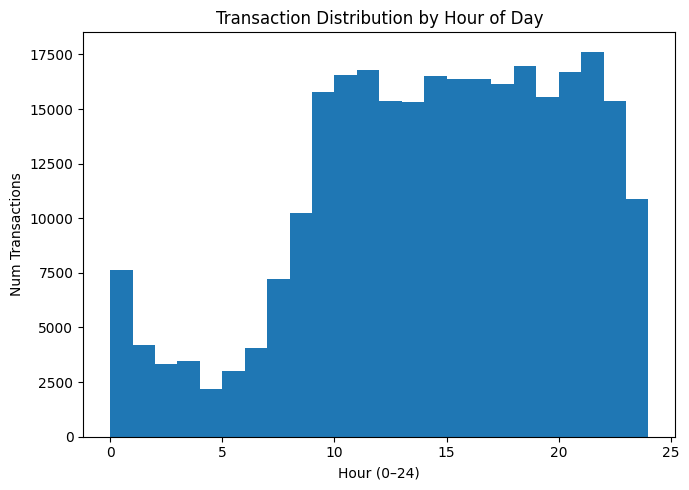

In [ ]:
time_vals = df_eng["Time"].values
time_z = (time_vals - time_vals.mean()) / time_vals.std()

# Raw Time
plt.figure()
plt.hist(time_vals, bins=50)
plt.title("Transaction Time (Raw)")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Standardized Time
plt.figure()
plt.hist(time_z, bins=50)
plt.title("Transaction Time (Standardized)")
plt.xlabel("Z-score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Hour-of-day
plt.figure()
plt.hist(df_eng["Hour"], bins=24)
plt.title("Transaction Distribution by Hour of Day")
plt.xlabel("Hour (0–24)")
plt.ylabel("Num Transactions")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    roc_auc_score,   # needed for k-fold AUC
)

# ============================
# BALANCED SUBSETS (RAW FEATURES ONLY)
# ============================

# Baseline subset (from original df, WITH duplicates)
fraud_base = df[df["Class"] == 1]
nonfraud_base = df[df["Class"] == 0].sample(
    n=len(fraud_base), random_state=42
)
df_base_raw = (
    pd.concat([fraud_base, nonfraud_base])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

print("Baseline subset shape:", df_base_raw.shape)
print("Baseline class balance:\n", df_base_raw["Class"].value_counts())

# Improved subset (from deduped + engineered df_eng)
fraud_imp = df_eng[df_eng["Class"] == 1]
nonfraud_imp = df_eng[df_eng["Class"] == 0].sample(
    n=len(fraud_imp), random_state=42
)
df_imp_raw = (
    pd.concat([fraud_imp, nonfraud_imp])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

print("\nImproved subset shape:", df_imp_raw.shape)
print("Improved class balance:\n", df_imp_raw["Class"].value_counts())


# ============================
# BASELINE MODEL (Time + Amount)
# - No scaling, no stratification, no k-fold
# ============================

X_base = df_base_raw[["Time", "Amount"]]
y_base = df_base_raw["Class"]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_base, y_base, test_size=0.3, random_state=42
)

baseline_model = LogisticRegression(max_iter=25000, solver="lbfgs")
baseline_model.fit(X_train_b, y_train_b)
y_scores_b = baseline_model.predict_proba(X_test_b)[:, 1]

# ROC & PR for baseline (single split)
fpr_b, tpr_b, _ = roc_curve(y_test_b, y_scores_b)
roc_auc_b = auc(fpr_b, tpr_b)

prec_b, rec_b, _ = precision_recall_curve(y_test_b, y_scores_b)
pr_auc_b = average_precision_score(y_test_b, y_scores_b)

print(f"\nBaseline Logistic Regression (Time + Amount):")
print(f"  ROC AUC = {roc_auc_b:.3f}")
print(f"  AP      = {pr_auc_b:.3f}")


# ============================
# IMPROVED MODEL (Time, Amount, LogAmount, Hour)
# - Uses deduped df_eng
# - Uses scaling + stratified split
# ============================

X_imp = df_imp_raw[["Time", "Amount", "LogAmount", "Hour"]]
y_imp = df_imp_raw["Class"]

# ---- Single stratified train/test split (used for plots) ----
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_imp, y_imp, test_size=0.3, random_state=42, stratify=y_imp
)

scaler_i = StandardScaler()
X_train_i_s = scaler_i.fit_transform(X_train_i)
X_test_i_s = scaler_i.transform(X_test_i)

improved_model = LogisticRegression(max_iter=25000, solver="lbfgs")
improved_model.fit(X_train_i_s, y_train_i)
y_scores_i = improved_model.predict_proba(X_test_i_s)[:, 1]

# ROC & PR for improved (single split)
fpr_i, tpr_i, _ = roc_curve(y_test_i, y_scores_i)
roc_auc_i = auc(fpr_i, tpr_i)

prec_i, rec_i, _ = precision_recall_curve(y_test_i, y_scores_i)
pr_auc_i = average_precision_score(y_test_i, y_scores_i)

print(f"\nImproved Logistic Regression (Time, Amount, LogAmount, Hour):")
print(f"  ROC AUC = {roc_auc_i:.3f}")
print(f"  AP      = {pr_auc_i:.3f}")


# ============================
# Stratified K-Fold evaluation
# ============================

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores_imp = []
ap_scores_imp = []

for train_idx, test_idx in skf.split(X_imp, y_imp):
    X_tr, X_te = X_imp.iloc[train_idx], X_imp.iloc[test_idx]
    y_tr, y_te = y_imp.iloc[train_idx], y_imp.iloc[test_idx]

    # Scale inside each fold to avoid data leakage
    scaler_fold = StandardScaler()
    X_tr_s = scaler_fold.fit_transform(X_tr)
    X_te_s = scaler_fold.transform(X_te)

    model_fold = LogisticRegression(max_iter=25000, solver="lbfgs")
    model_fold.fit(X_tr_s, y_tr)

    y_te_scores = model_fold.predict_proba(X_te_s)[:, 1]

    auc_scores_imp.append(roc_auc_score(y_te, y_te_scores))
    ap_scores_imp.append(average_precision_score(y_te, y_te_scores))

print("\nImproved Logistic Regression (Stratified 5-Fold on balanced subset):")
print(f"  Mean ROC AUC = {np.mean(auc_scores_imp):.3f} ± {np.std(auc_scores_imp):.3f}")
print(f"  Mean AP      = {np.mean(ap_scores_imp):.3f} ± {np.std(ap_scores_imp):.3f}")

Baseline subset shape: (984, 31)
Baseline class balance:
 Class
0    492
1    492
Name: count, dtype: int64

Improved subset shape: (946, 33)
Improved class balance:
 Class
1    473
0    473
Name: count, dtype: int64

Baseline Logistic Regression (Time + Amount):
  ROC AUC = 0.607
  AP      = 0.625

Improved Logistic Regression (Time, Amount, LogAmount, Hour):
  ROC AUC = 0.662
  AP      = 0.646

Improved Logistic Regression (Stratified 5-Fold on balanced subset):
  Mean ROC AUC = 0.651 ± 0.048
  Mean AP      = 0.646 ± 0.037


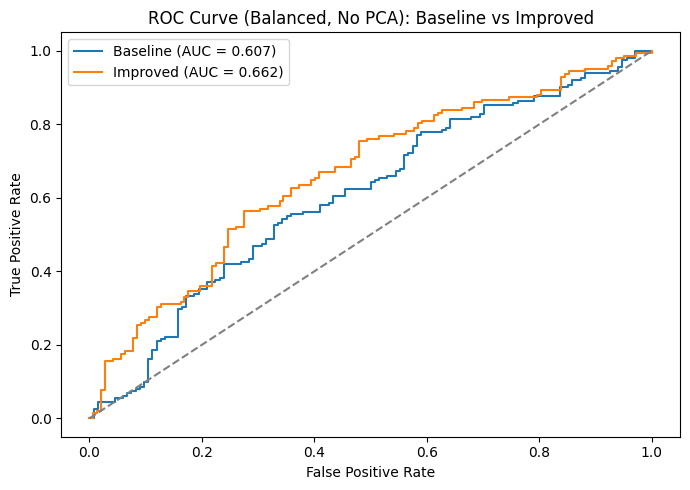

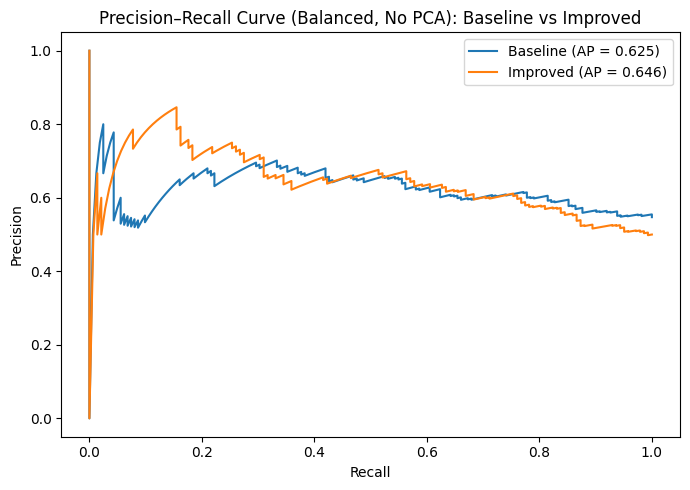

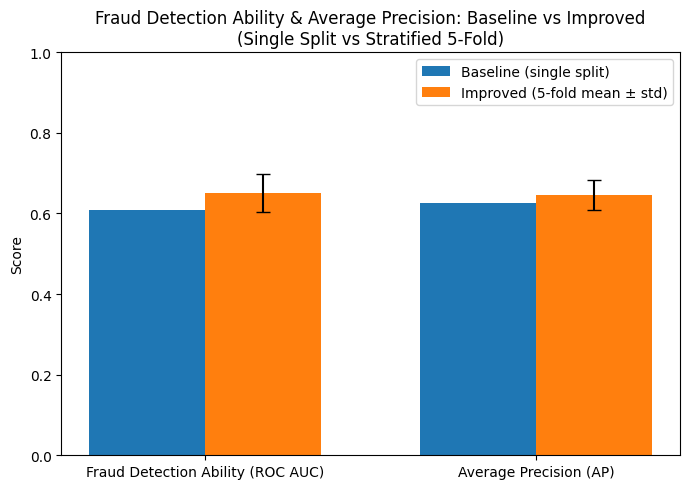

In [ ]:
# ============================
# 1) ROC Curve: Baseline vs Improved (single split)
# ============================
plt.figure(figsize=(7, 5))
plt.plot(fpr_b, tpr_b, label=f"Baseline (AUC = {roc_auc_b:.3f})")
plt.plot(fpr_i, tpr_i, label=f"Improved (AUC = {roc_auc_i:.3f})")
plt.plot([0, 1], [0, 1], "--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Balanced, No PCA): Baseline vs Improved")
plt.legend()
plt.tight_layout()
plt.show()

# ============================
# 2) Precision–Recall Curve: Baseline vs Improved (single split)
# ============================
plt.figure(figsize=(7, 5))
plt.plot(rec_b, prec_b, label=f"Baseline (AP = {pr_auc_b:.3f})")
plt.plot(rec_i, prec_i, label=f"Improved (AP = {pr_auc_i:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Balanced, No PCA): Baseline vs Improved")
plt.legend()
plt.tight_layout()
plt.show()

# ============================
# 3) K-Fold Summary: Baseline vs Improved
#    - Baseline: single split
#    - Improved: 5-fold mean ± std
# ============================

improved_auc_mean = np.mean(auc_scores_imp)
improved_auc_std = np.std(auc_scores_imp)
improved_ap_mean = np.mean(ap_scores_imp)
improved_ap_std = np.std(ap_scores_imp)

metrics = ["Fraud Detection Ability (ROC AUC)", "Average Precision (AP)"]

baseline_vals = [roc_auc_b, pr_auc_b]
improved_means = [improved_auc_mean, improved_ap_mean]
improved_stds = [improved_auc_std, improved_ap_std]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(7, 5))
plt.bar(x - width/2, baseline_vals, width, label="Baseline (single split)")
plt.bar(
    x + width/2,
    improved_means,
    width,
    yerr=improved_stds,
    capsize=5,
    label="Improved (5-fold mean ± std)",
)

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.title("Fraud Detection Ability & Average Precision: Baseline vs Improved\n(Single Split vs Stratified 5-Fold)")
plt.legend()
plt.tight_layout()
plt.show()